# Predicting Heart Disease
The World Health Organization (WHO) estimates that 17.9 million people die every year because of cardiovascular diseases (CVDs).

There are multiple risk factors that could contribute to CVD in an individual such as unhealthy diet, lack of physical activity or mental illnesses. Being able to identify these risk factors in individuals early on could help prevent a lot of premature deaths.

In this project, we will use the Kaggle dataset and build a K-Nearest Neighbors classifier to accurately predict the likelihood of a patient having a heart disease in the future.

In [131]:
#import the libraries needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [132]:
#read the file
df= pd.read_csv("heart_disease_prediction.csv")
df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0


In [133]:
#preview data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [134]:

df.dtypes.value_counts()

int64      6
object     5
float64    1
dtype: int64

### EDA
### Descriptive statistics

In [135]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


From the table above, we can observe that:

The average age of patients is ~53 years.
The median for Cholesterol is higher than its mean by roughly 25 mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
RestingBP and Cholesterol have a minimum value of zero.
There don't seem to be any missing values in these columns. But we will have to confirm it across the entire dataset as well.
RestingBP can't be 0. And, as per the American Heart Association, serum cholesterol is a composite of different measurements. So, it is unlikely that Cholesterol would be 0 as well. We will have to clean both of these up later.

Next, we will look at the categorical variables. It would also be beneficial to look at how the target feature, HeartDisease, is related to those categories. Before that, let's quickly check if there are any missing values in the dataset or not.

In [136]:
# check for missing values
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [137]:
df.describe(include=['object'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


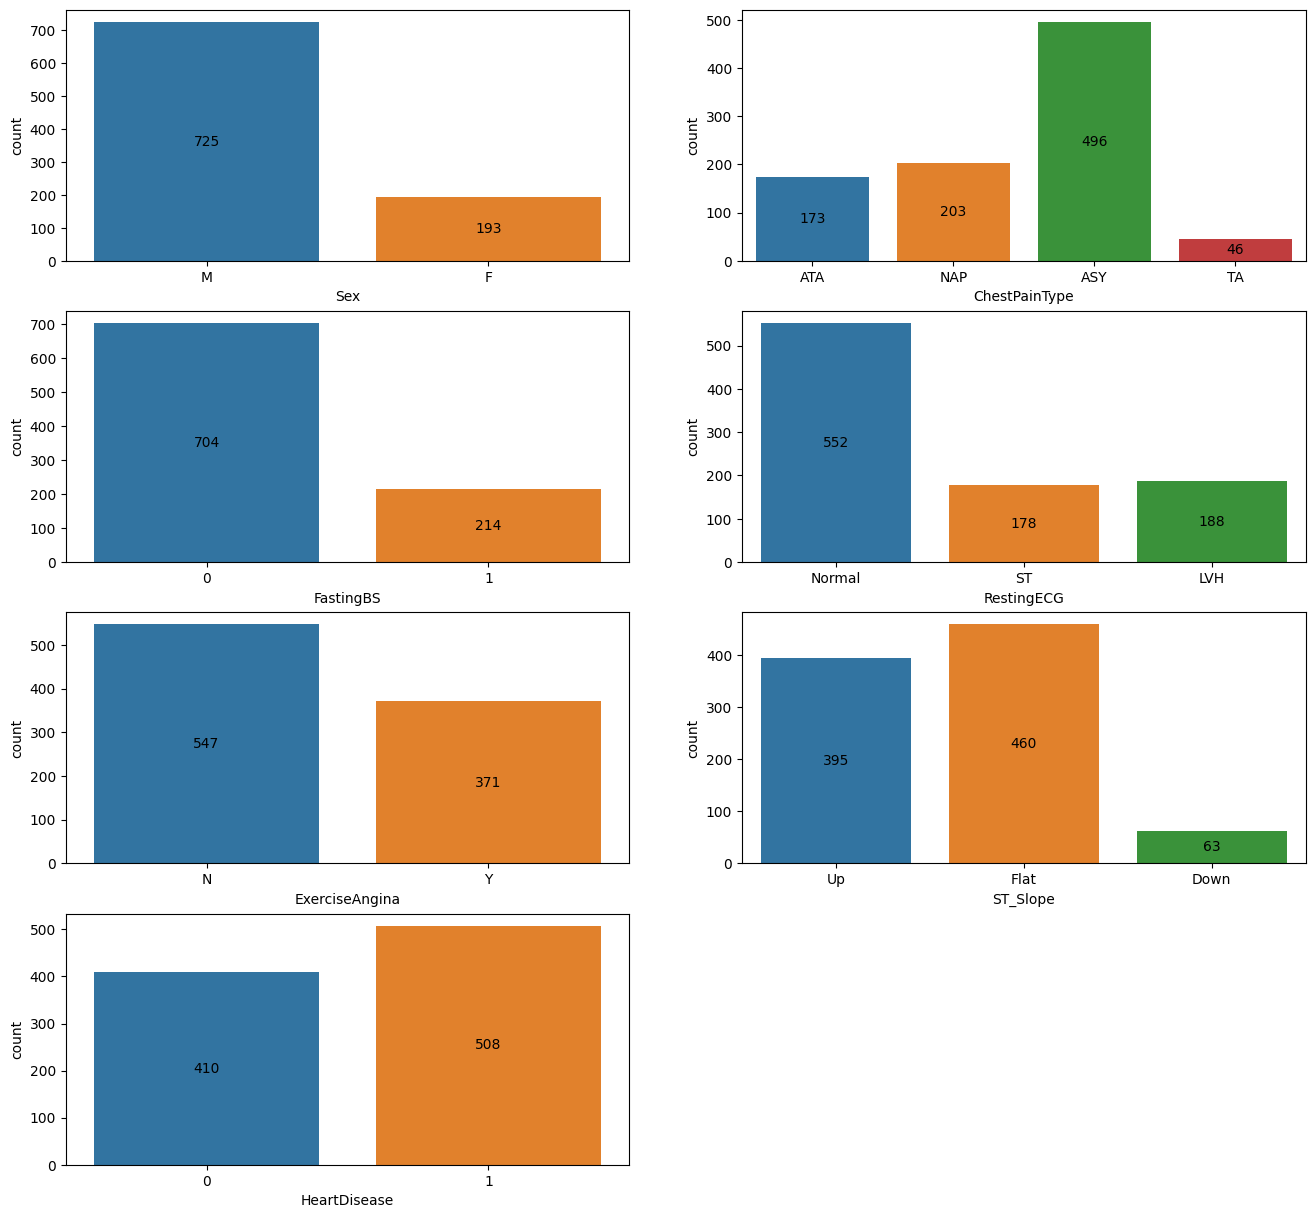

In [138]:
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=df[col], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

### GROUPING THE DATA USING HEART DISEASE


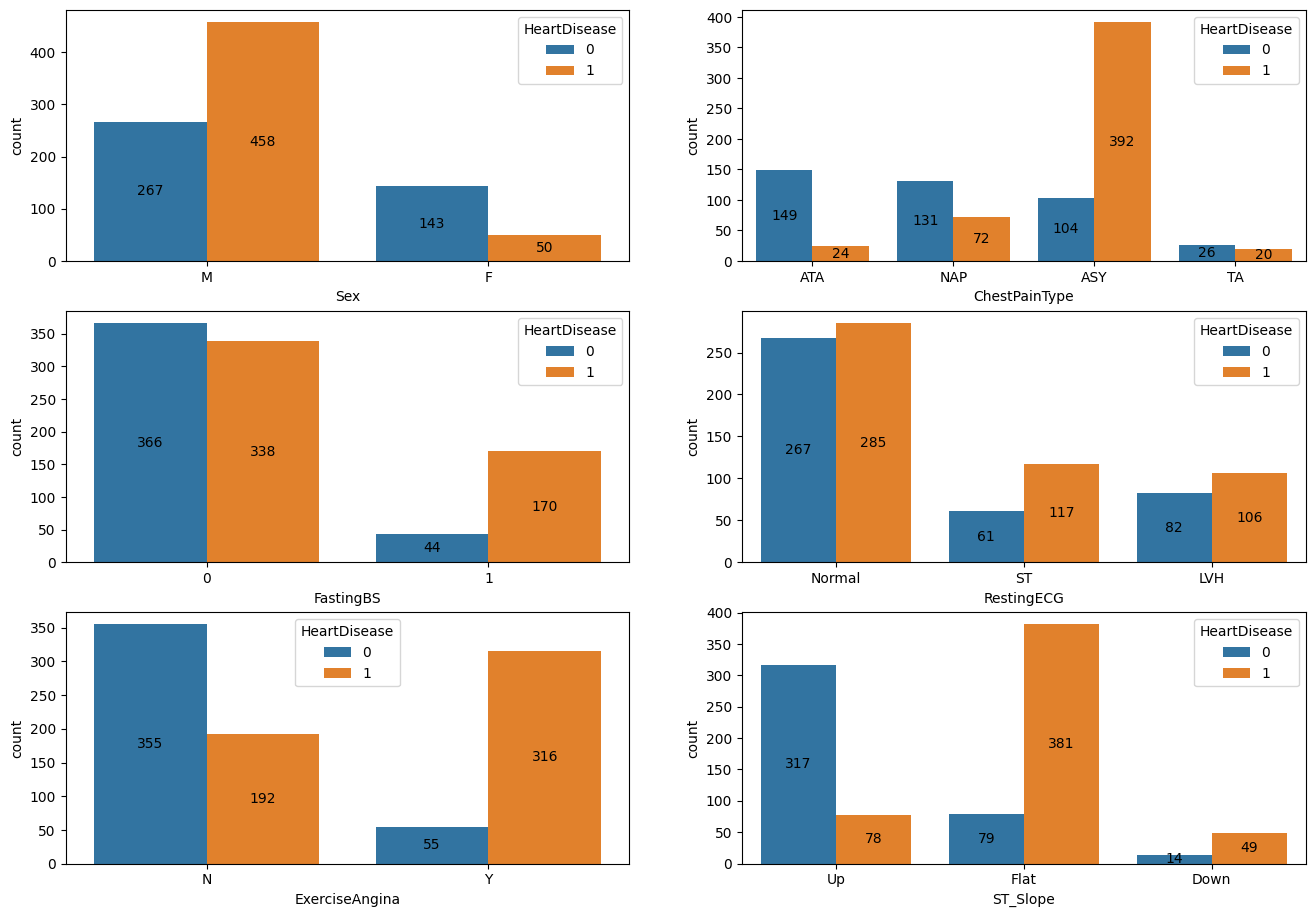

In [139]:
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols[:-1]):
    ax = plt.subplot(4, 2, idx+1)
    # group by HeartDisease
    sns.countplot(x=df[col], hue=df["HeartDisease"], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

We can further notice how skewed the dataset is towards male patients. Only 50 female patients in the dataset have been diagnosed with heart disease.

A significant number of patients, 392, diagnosed with heart disease have asymptomatic (ASY) chest pain. While chest pain could be a relevant feature for our model, asymptomatic implies that those patients who had a heart disease did not have chest pain as a symptom.

A high number (170) of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease in relation to those who were not diagnosed as such.

Out of all patients who had an exercise-induced angina, 316 were diagnosed with a heart disease.

Out of all patients with a flat ST slope, 381 were diagnosed with a heart disease.

Looking at the data distribution from the above plots, we can start to identify some features that could be relevant to us. 

We will clean up the dataset a bit first before narrowing down on our features.

### DATA CLEANING

In [140]:
df[df["RestingBP"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [141]:
df[df["Cholesterol"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


RestingBP has only one zero value. We can remove that row from consideration. There are 172 zero values for Cholesterol. That's a relatively high number. We can't remove them all and replacing those values with the median might not be an ideal approach, but that's what we will go for now.

To be more accurate, we will replace the zero values in Cholesterol in relation to HeartDisease. So, the 0 values in Cholesterol for patients who were diagnosed with a heart disease will be replaced by the median of the non-zero values for patients who were diagnosed with a heart disase. And we'll do the same for those who were not diagnosed with a heart disease.

In [142]:
df_clean = df.copy()

# only keep non-zero values for RestingBP
df_clean = df_clean[df_clean["RestingBP"] != 0]

heartdisease_mask = df_clean["HeartDisease"]==0

cholesterol_without_heartdisease = df_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = df_clean.loc[~heartdisease_mask, "Cholesterol"]

df_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())
df_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value =cholesterol_with_heartdisease.median())

In [143]:
df_clean[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


### FEATURE SELECTION
Select features to build our model

In [144]:
df.corr()

C:\Users\Admin\AppData\Local\Temp\ipykernel_13764\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.258612,0.282039
RestingBP,0.254399,1.000000,0.100893,0.070193,-0.112135,0.164803,0.107589
Cholesterol,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.050148,-0.232741
FastingBS,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.052698,0.267291
MaxHR,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.160691,-0.400421
Oldpeak,0.258612,0.164803,0.050148,0.052698,-0.160691,1.000000,0.403951
HeartDisease,0.282039,0.107589,-0.232741,0.267291,-0.400421,0.403951,1.000000


In [145]:
#convert categorical columns into dummy variables
df_clean = pd.get_dummies(df_clean,drop_first=True)
df_clean.head(2)



,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0


<Axes: >

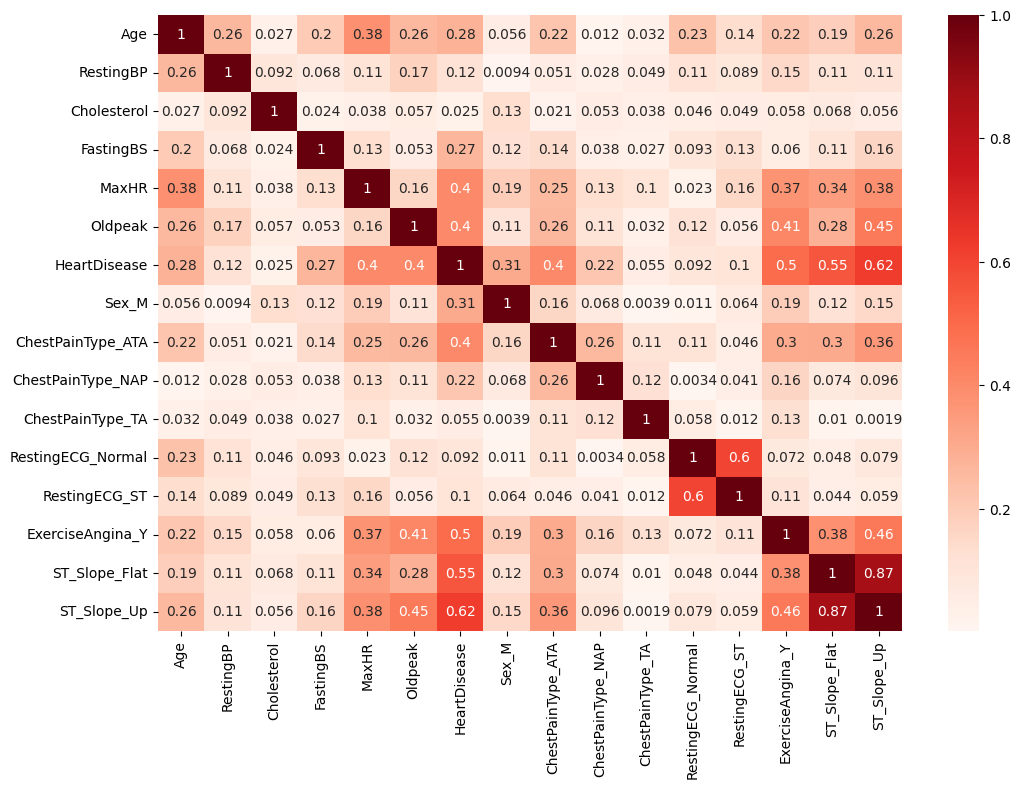

In [146]:
correlations = abs(df_clean.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap="Reds")

<Axes: >

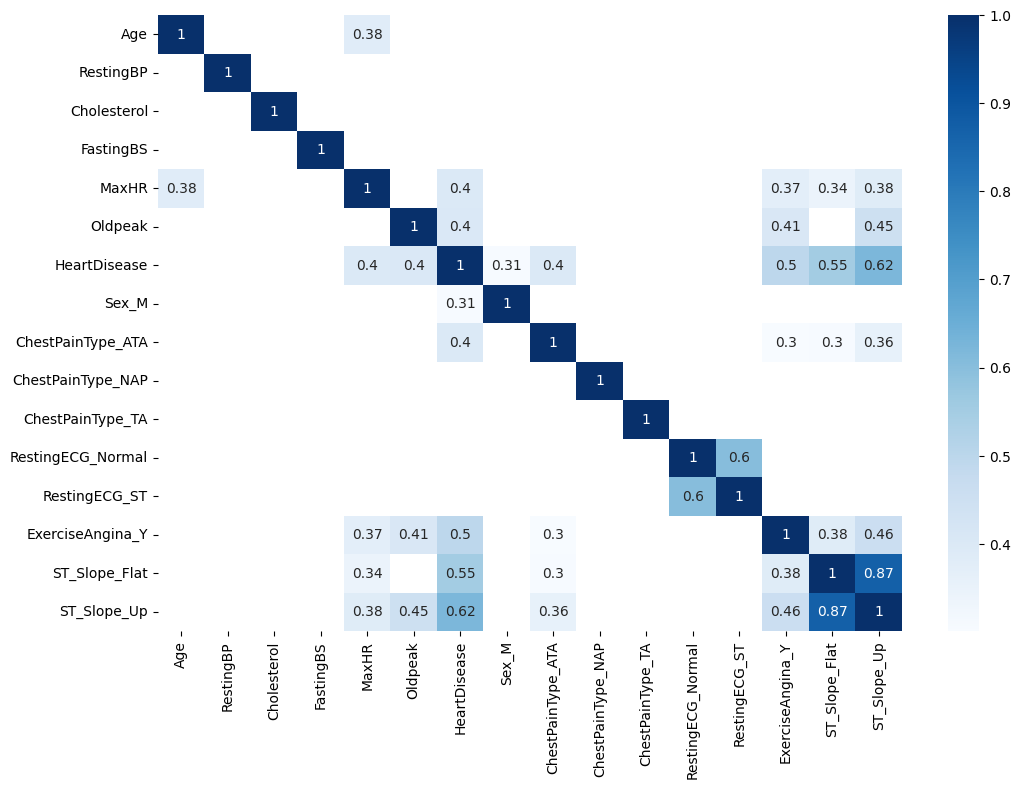

In [147]:
plt.figure(figsize=(12,8))
sns.heatmap(correlations[correlations > 0.3], annot=True, cmap="Blues")

From our correlation heatmap, we can identify the following features to be positively correlated (correlation coefficient greater than 0.3) to HeartDisease:

Oldpeak

MaxHR

ChestPainType_ATA

ExerciseAngina_Y

ST_Slope_Flat

ST_Slope_Up

The correlation coefficient threshold was chosen arbitrarily. Surprisingly, Cholesterol is not strongly correlated to HeartDisease. We can consider ignoring the feature for now.

Given everything we have attempted so far, we can narrow down our features to the following:

Oldpeak

Sex_M

It has a relatively low value for the coefficient, but given what we observed in our EDA, let's also take it into account.

ExerciseAngina_Y

ST_Slope_Flat

ST_Slope_Up

Time to create our model using these features!

### Building a Classifier 1


In [148]:
# Splitting the data into training and validation dataset
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

In [149]:
#Split the data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=233)
features=[
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",

    "ST_Slope_Flat",
    "ST_Slope_Up"
]


In [150]:
#build model and evaluate efficiency
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 5)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_test[[feature]], y_test)
    print(f"The k-NN classifier trained on {feature} and with k = 5 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on Oldpeak and with k = 5 has an accuracy of 67.93%
The k-NN classifier trained on Sex_M and with k = 5 has an accuracy of 61.41%
The k-NN classifier trained on ExerciseAngina_Y and with k = 5 has an accuracy of 70.11%
The k-NN classifier trained on ST_Slope_Flat and with k = 5 has an accuracy of 80.98%
The k-NN classifier trained on ST_Slope_Up and with k = 5 has an accuracy of 84.24%


Our best forming model, with an accuracy of ~82%, was trained on the ST_Slope_Flat feature with ExerciseAngina_Y being a close second. These make sense given the data distributions we saw previously.

We will train a model using all of these features next.

### CLASSIFIER WITH MORE FEATURES

In [151]:
#normalize our data to the range(0,1)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_test_scaled = scaler.transform(X_test[features])

In [152]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_test_scaled, y_test)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 77.72


The Accuracy has not increased considerably


### HYPERPARAMETER TUNING

In [153]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

In [154]:
X_train,X_test,y_train,y_test =train_test_split(X,y ,test_size=0.3,random_state=427)
features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
] 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])






We will use grid search to explore the following range of values for a couple of hyperparameters:

For k (n_neighbors in scikit-learn) we will use values in the range of 1 to 20.
We will use two distance metrics - minkwoski and manhattan.
minkwoski is the default metric for KNeighborsClassifier in sklearn, so we don't expect manhattan to do better. But, let's see what happens!

In [155]:
grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [156]:
knn_grid.best_score_*100, knn_grid.best_params_

(84.7080910852713, {'metric': 'minkowski', 'n_neighbors': 17})

Our best model had an accuracy of ~84% with 17 n_neighbors and minkowski as the distance metric.

The accuracy of this model is only slightly better. Since GridSearchCV employs a cross-validation approach, it is reasonable to assume that this is a better estimate of how the model performs compared to our prior attempt.

We will evaluate our model on our test set now.

### DATA TESTING


In [157]:
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 83.70


 Model Accuracy on test set: 83.70
Our model got an accuracy of ~84%. That's really good! This means that our model is likely to correctly predict whether a patient is at risk for a heart disease ~84% of the time.



### SUMMARY
Our final model was trained using the following features:

Oldpeak

Sex_M

ExerciseAngina_Y

ST_Slope_Flat

ST_Slope_Up

and had a test set accuracy of 83.70%. However, given the limitations of our data this accuracy might not be indicative of a well performing model.

There are quite a few things we could try next to get better results:

Try out different features.
Expand the grid search parameters to identify more optimal hyperparameters.
Explore other algorithms that might perform better than k-NN.
Try and collect more data.